# Simulate PTA with PTA-replicator and Enterprise

In [1]:
from pta_replicator_main.pta_replicator.simulate import load_from_directories
from pta_replicator_main.pta_replicator.simulate import make_ideal
from pta_replicator_main.pta_replicator.white_noise import add_measurement_noise
from pta_replicator_main.pta_replicator.red_noise import add_red_noise, add_gwb
from pta_replicator_main.pta_replicator.deterministic import add_cgw

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from random import sample, seed

import params_injected
from pulsar_phase import get_psr_phase

%load_ext autoreload
%autoreload 2

## Simulate pulsars

In [2]:
pardir = 'partim/par'
timdir = 'partim/tim'
num_psrs = params_injected.num_psrs
# psrs = load_from_directories(pardir, timdir, num_psrs=num_psrs)
psrs_full = load_from_directories(pardir, timdir, num_psrs=50)
seed(0)
psrs = sample(psrs_full, k=num_psrs)

2025-08-04 11:04:02.477 | DEBUG    | pint.toa:__init__:1358 - No pulse number flags found in the TOAs
2025-08-04 11:04:02.478 | DEBUG    | pint.toa:apply_clock_corrections:2200 - Applying clock corrections (include_gps = True, include_bipm = True)
2025-08-04 11:04:02.486 | INFO     | pint.observatory:gps_correction:210 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-04 11:04:02.486 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2025-08-04 11:04:02.491 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-08-04 11:04:02.494 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/Users/aidengundersen/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2025-08-04 11:04:02.512 | INFO     | pint.

In [3]:
psrs[0].name

'J1312+0051'

In [4]:
# store injected parameters
x_inj = {}

# add signals and noise
psr_phases = np.zeros(num_psrs)
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    # add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr,
                          efac=params_injected.efac_inj, 
                          seed=params_injected.efac_seed + ii)

    ## add red noise
    if params_injected.rn_model:
        add_red_noise(psr,
                      log10_amplitude=params_injected.RN_logamps_inj[ii],
                      spectral_index=params_injected.RN_gammas_inj[ii],
                      components=params_injected.num_modes,
                      seed=params_injected.RN_seed + ii)
        x_inj[f'{psr.name}_red_noise_log10_A'] = params_injected.RN_logamps_inj[ii]
        x_inj[f'{psr.name}_red_noise_gamma'] = params_injected.RN_gammas_inj[ii]
    
    ## add continuous wave
    if params_injected.cw_model:
        ent_psr = psr.to_enterprise()
        psr_dist = ent_psr.pdist[0]
        psr_phase = get_psr_phase(params_injected.CW_params_inj, ent_psr.pos, psr_dist)
        psr_phases[ii] = psr_phase
        psr_params = np.array([psr_dist, psr_phase])
        add_cgw(psr, params_injected.CW_params_inj, psr_params, ent_psr.toas, ent_psr.pos)

    print(ii, psr.name)

2025-08-04 11:04:13.039 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-04 11:04:13.040 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-04 11:04:13.040 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-04 11:04:13.041 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-04 11:04:13.057 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-04 11:04:13.058 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-04 11:04:13.058 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-04 11:04:13.059 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-04 11:04:13.059 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

0 J1312+0051


2025-08-04 11:04:13.732 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-04 11:04:13.733 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-04 11:04:13.734 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-04 11:04:13.734 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-04 11:04:13.735 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. Removing...
2025-08-04 11:04:13.735 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_saturn_pos already exists. Removing...
2025-08-04 11:04:13.735 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_venus_pos already exists. Removing...
2025-08-04 11:04:13.736 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_uranus_pos already exists. Removing...
2025-08-04 11:04:13.736 | DEBUG    | pin

1 J1909-3744


2025-08-04 11:04:14.306 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-08-04 11:04:14.306 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.308 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.309 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.312 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.315 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.316 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.319 | INFO     | pint.sol

2 J1455-3330


2025-08-04 11:04:14.859 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.860 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.861 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.863 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.864 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.866 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:14.868 | DEBUG    | pint.toa:compute_posvels:2417 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos obs_jupiter_pos obs_saturn_pos obs_venus_pos obs_uranus_po

3 B1953+29


2025-08-04 11:04:15.431 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_neptune_pos already exists. Removing...
2025-08-04 11:04:15.434 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_earth_pos already exists. Removing...
2025-08-04 11:04:15.439 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:15.463 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409709e+09  1.34555717e+11  5.83294451e+10] m
2025-08-04 11:04:15.464 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:15.466 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:15.467 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:15.469 | INFO     | pint.solar_system_ephemerides:load_kernel:12

4 J0709+0458


In [5]:
if params_injected.gwb_model:
        add_gwb(psrs,
                log10_amplitude=params_injected.GWB_logamp_inj,
                spectral_index=params_injected.GWB_gamma_inj,
                seed=params_injected.GWB_seed)

In [6]:
# fit timing model
for psr in psrs:
    print(psr.name)
    psr.fit()

2025-08-04 11:04:15.810 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1312+0051


2025-08-04 11:04:16.617 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0007800564061506421
2025-08-04 11:04:16.978 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1909-3744


2025-08-04 11:04:17.768 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0014057147940553794
2025-08-04 11:04:17.819 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1455-3330


2025-08-04 11:04:18.612 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0027971652789520185
2025-08-04 11:04:18.664 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


B1953+29


2025-08-04 11:04:20.746 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 4: chi2 does not improve, stopping; decrease: -0.0017851830768478294
2025-08-04 11:04:20.798 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0709+0458


2025-08-04 11:04:21.604 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.009992483277782682


J1312+0051


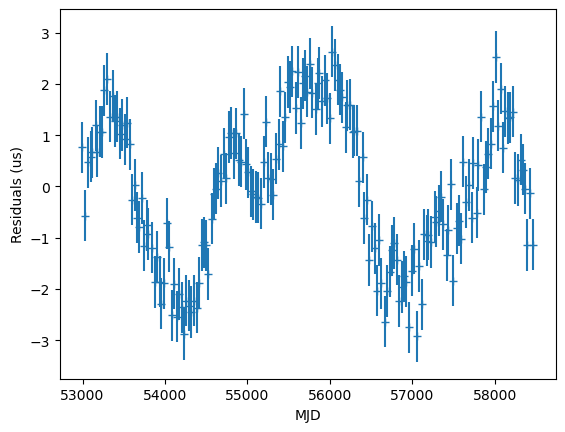

J1909-3744


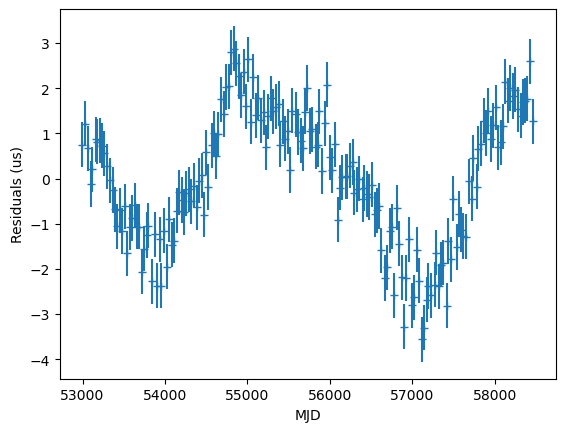

J1455-3330


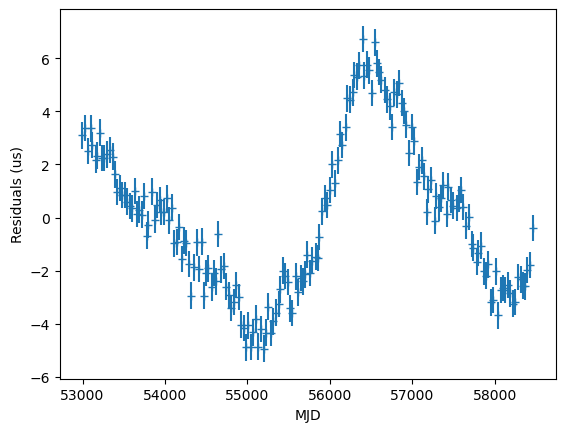

B1953+29


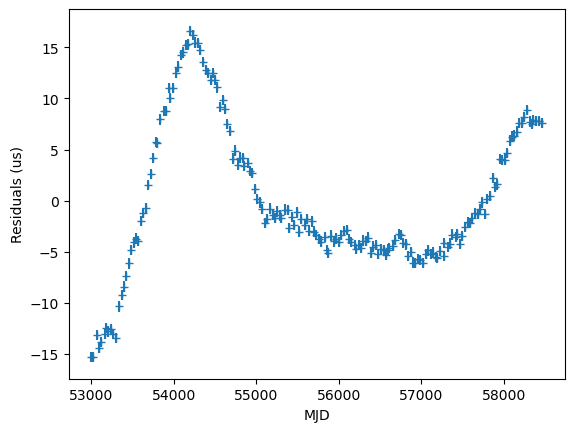

J0709+0458


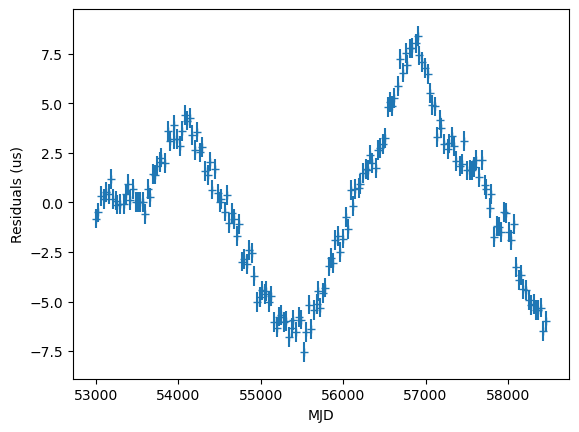

In [7]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()

In [8]:
# convert to enterprise type pulsars
ent_psrs = []
for psr in psrs:
    ent_psrs.append(psr.to_enterprise())

2025-08-04 11:04:22.723 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:22.742 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-04 11:04:22.742 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-04 11:04:23.196 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:23.215 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-04 11:04:23.216 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-04 11:04:23.657 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-04 11:04:23.676 | DEBUG    | pint.toa:add_vel_ecl:2467 - Adding column ssb_obs_vel_ecl
2025-08-04 11:04:23.676 | DEBUG    | pint.models.astrometry:ssb_

In [9]:
# save Enterprise pulsar objects
with open('data/enterprise_pulsars.pkl', 'wb') as f:
    pickle.dump(ent_psrs, f)

## Make PTA

In [10]:
# use built in backend selection
backend = selections.Selection(selections.by_backend)

# EFAC parameter
if params_injected.wn_model:
    efac_param = parameter.Uniform(0.5, 3.0)
else:
    efac_param = params_injected.efac_inj

# make white noise
wn = white_signals.MeasurementNoise(efac=efac_param,
                                    log10_t2equad=-1000, 
                                    selection=backend)

In [11]:
# red noise
if params_injected.rn_model:
    logamp_param = parameter.Uniform(-18., -11.)
    gamma_param = parameter.Uniform(1., 7.)

    # get power law in prior
    powlaw = gp_priors.powerlaw(log10_A=logamp_param, gamma=gamma_param)

    # make red noise
    rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=params_injected.num_modes)

In [12]:
# GWB
if params_injected.gwb_model:
    log10_A_gw = parameter.Uniform(-18., -11.)('log10_A_gw')
    gamma_gw = parameter.Uniform(1., 7.)('gamma_gw')
    cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
    gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(),
                                         components=params_injected.num_modes, name='gw')

In [13]:
# make CW signal
if params_injected.cw_model:
    cw = cw_block_circ(dist_prior='log-uniform', psrTerm=True)

In [14]:
# make timing model
tm = gp_signals.TimingModel(use_svd=True)

In [15]:
# make model and PTA object
model = tm + wn
if params_injected.rn_model:
    model += rn
if params_injected.gwb_model:
    model += gw
if params_injected.cw_model:
    model += cw
    
pta = signal_base.PTA([model(psr) for psr in ent_psrs])

In [16]:
# save PTA object
with open('data/pta.pkl', 'wb') as f:
    dill.dump(pta, f)

print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1312+0051_red_noise                     FourierBasisGP                 2                   

params:
J1312+0051_red_noise_log10_A:Uniform(pmin=-18.0, pmax=-11.0)                              
J1312+0051_red_noise_gamma:Uniform(pmin=1.0, pmax=7.0)                                    
__________________________________________________________________________________________
J1909-3744_linear_timing_model_svd       TimingModel                    0                   

params:
_______

In [17]:
# save data
Fs = np.array([basis[:, 8:] for basis in pta.get_basis()])
Ms = np.array([ent_psr.Mmat for ent_psr in ent_psrs])
Ns = np.array([np.diag(ent_psr.toaerrs**2.) for ent_psr in ent_psrs])
toas = np.array([ent_psr.toas for ent_psr in ent_psrs])
residuals = np.array([ent_psr.residuals for ent_psr in ent_psrs])
psr_pos = np.array([ent_psr.pos for ent_psr in ent_psrs])
psr_names = np.array([ent_psr.name for ent_psr in ent_psrs])
psr_dists = np.array([[psr.pdist[0], psr.pdist[1]] for psr in ent_psrs]).T

# save data in dictionary
data_dict = {}
data_dict['Fs'] = Fs
data_dict['Ms'] = Ms
data_dict['Ns'] = Ns
data_dict['toas'] = toas
data_dict['residuals'] = residuals
data_dict['psr_pos'] = psr_pos
data_dict['psr_names'] = psr_names
data_dict['psr_dists'] = psr_dists
data_dict['psr_phases'] = psr_phases
data_dict['x_inj'] = x_inj
np.savez_compressed('data/data_dict.npz', **data_dict)

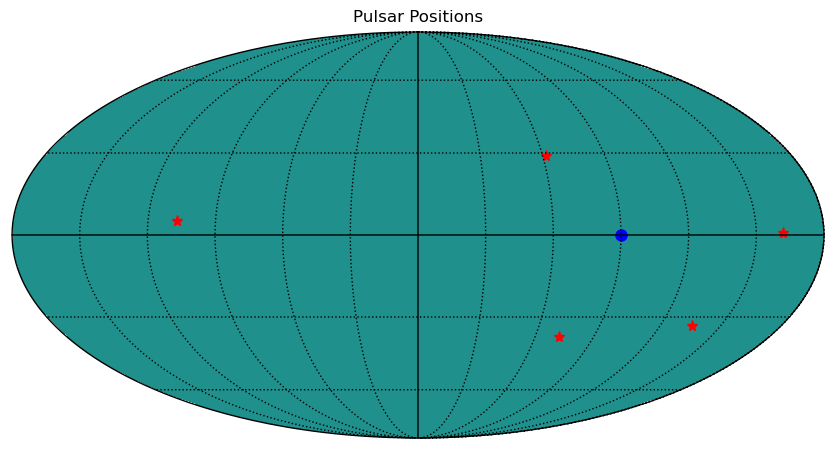

In [18]:
# plot pulsar positions
theta_psr = np.arccos(psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.arctan2(psr_pos[:, 1], psr_pos[:, 0])  # atan2(y, x)
phi_psr = np.mod(phi_psr, 2 * np.pi)


# Convert to HEALPix map
nside = 64
npix = hp.nside2npix(nside)

# Plot
hp.mollview(np.zeros(hp.nside2npix(64)), title="Pulsar Positions", cbar=False)
hp.projplot(theta_psr, phi_psr, 'r*', markersize=8)
hp.projplot(params_injected.gwtheta_inj, params_injected.gwphi_inj, 'bo', markersize=8)
hp.graticule()
plt.show()